# Face Analysis with UniFace

This notebook demonstrates comprehensive face analysis using the **FaceAnalyzer** class.

## 1. Install UniFace

In [1]:
%pip install -q uniface

# Clone repo for assets (Colab only)
import os
if 'COLAB_GPU' in os.environ or 'COLAB_RELEASE_TAG' in os.environ:
    if not os.path.exists('uniface'):
        !git clone --depth 1 https://github.com/yakhyo/uniface.git
    os.chdir('uniface/examples')

Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries

In [2]:
import cv2
import matplotlib.pyplot as plt

import uniface
from uniface.analyzer import FaceAnalyzer
from uniface.detection import RetinaFace
from uniface.recognition import ArcFace
from uniface.attribute import AgeGender
from uniface.visualization import draw_detections

print(uniface.__version__)

2.0.0


## 3. Initialize FaceAnalyzer

The `FaceAnalyzer` combines detection, recognition, and attribute prediction in one class.

In [3]:
analyzer = FaceAnalyzer(
    detector=RetinaFace(confidence_threshold=0.5),
    recognizer=ArcFace(),
    age_gender=AgeGender()
)

## 4. Analyze Faces in Images

In [4]:
image_paths = [
    '../assets/test_images/image0.jpg',
    '../assets/test_images/image1.jpg',
    '../assets/test_images/image2.jpg',
]

results = []

for image_path in image_paths:
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f'Error: Could not read {image_path}')
        continue

    # Analyze faces - returns list of Face objects
    faces = analyzer.analyze(image)
    print(f'\n{image_path.split("/")[-1]}: Detected {len(faces)} face(s)')

    # Print face attributes
    for i, face in enumerate(faces, 1):
        print(f'  Face {i}: {face.sex}, {face.age}y')

    # Prepare visualization (without text overlay)
    vis_image = image.copy()
    bboxes = [f.bbox for f in faces]
    scores = [f.confidence for f in faces]
    landmarks = [f.landmarks for f in faces]
    draw_detections(image=vis_image, bboxes=bboxes, scores=scores, landmarks=landmarks, vis_threshold=0.5, fancy_bbox=True)

    results.append((image_path, cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB), faces))


image0.jpg: Detected 1 face(s)
  Face 1: Female, 28y

image1.jpg: Detected 1 face(s)
  Face 1: Female, 29y

image2.jpg: Detected 1 face(s)
  Face 1: Female, 28y


## 5. Visualize Results

Display images with face information shown below each image.

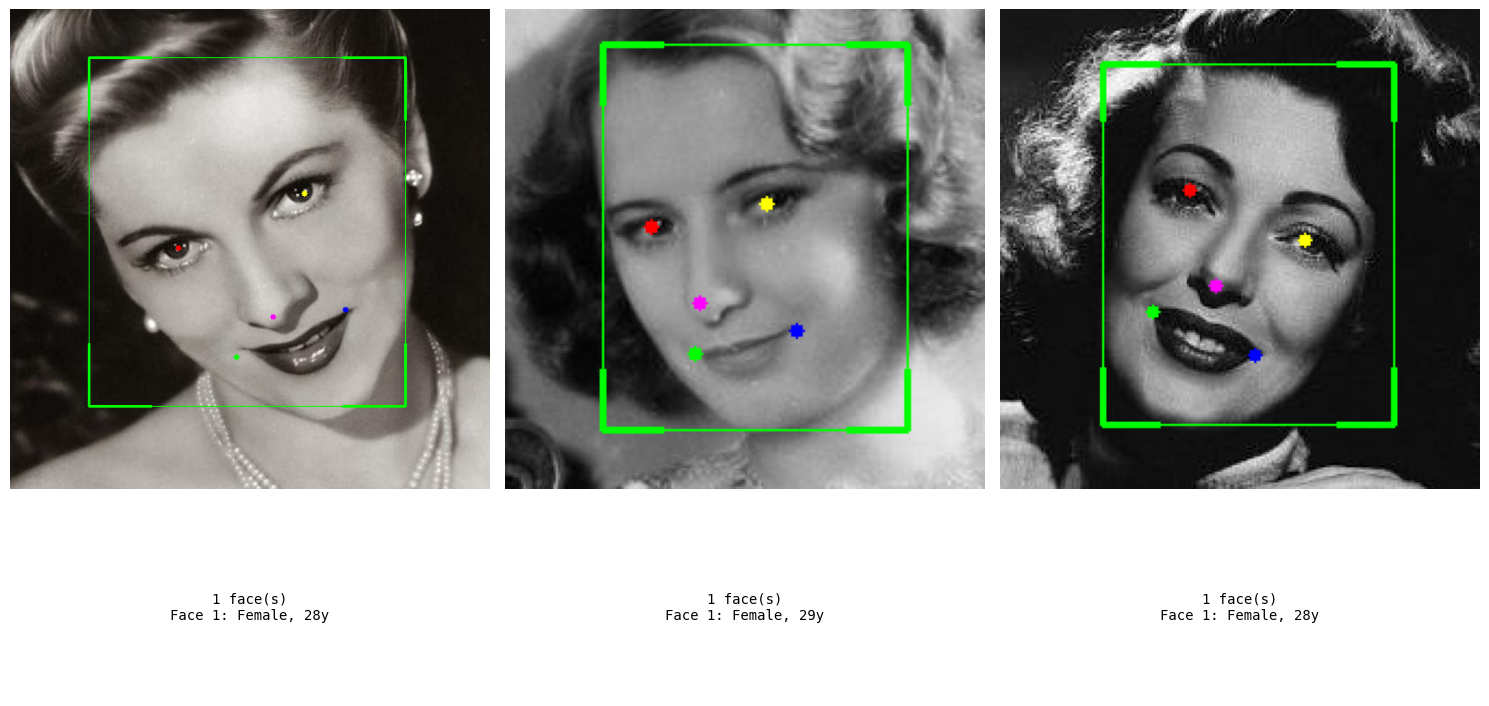

In [5]:
fig, axes = plt.subplots(2, len(results), figsize=(15, 8),
                         gridspec_kw={'height_ratios': [4, 1]})

for idx, (path, vis_image, faces) in enumerate(results):
    # Display image
    axes[0, idx].imshow(vis_image)
    axes[0, idx].axis('off')

    # Display face information below image
    axes[1, idx].axis('off')
    info_text = f'{len(faces)} face(s)\n'
    for i, face in enumerate(faces, 1):
        info_text += f'Face {i}: {face.sex}, {face.age}y\n'

    axes[1, idx].text(0.5, 0.5, info_text,
                      ha='center', va='center',
                      fontsize=10, family='monospace')

plt.tight_layout()
plt.show()

## 6. Access Face Attributes

Each `Face` object contains detection, recognition, and attribute data.

In [6]:
# Get first face from first image
_, _, faces = results[0]
if faces:
    face = faces[0]

    print('Face Attributes:')
    print(f'  - Bounding box: {face.bbox.astype(int).tolist()}')
    print(f'  - Confidence: {face.confidence:.3f}')
    print(f'  - Landmarks shape: {face.landmarks.shape}')
    print(f'  - Age: {face.age} years')
    print(f'  - Gender: {face.sex}')
    print(f'  - Embedding shape: {face.embedding.shape}')
    print(f'  - Embedding dimension: {face.embedding.shape[1]}D')

Face Attributes:
  - Bounding box: [88, 54, 442, 444]
  - Confidence: 1.000
  - Landmarks shape: (5, 2)
  - Age: 28 years
  - Gender: Female
  - Embedding shape: (1, 512)
  - Embedding dimension: 512D


## 7. Compare Face Similarity

Use face embeddings to compute similarity between faces.

In [7]:
# Compare first two faces
if len(results) >= 2:
    face1 = results[0][2][0]  # First face from first image
    face2 = results[1][2][0]  # First face from second image

    similarity = face1.compute_similarity(face2)
    print(f'Similarity between faces: {similarity:.4f}')
    print(f'Same person: {"Yes" if similarity > 0.6 else "No"} (threshold=0.6)')

Similarity between faces: 0.1135
Same person: No (threshold=0.6)


## Notes

- `analyzer.analyze()` performs detection, recognition, and attribute prediction in one call
- Each `Face` object contains: `bbox`, `confidence`, `landmarks`, `embedding`, `age`, `gender`
- Gender is available as both ID (0=Female, 1=Male) and string via `face.sex` property
- Face embeddings are L2-normalized (norm ≈ 1.0) for similarity computation
- Use `face.compute_similarity(other_face)` to compare faces (returns cosine similarity)
- Typical similarity threshold: 0.6 (same person if similarity > 0.6)